<a href="https://colab.research.google.com/github/korobov-alex/ML_price-prediction/blob/main/Amsterdam_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#All the libralies used in this project

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [ ]:
data = pd.read_csv('HousingPrices-Amsterdam-August-2021.csv')
data.head()

In [ ]:
data.shape

In [ ]:
data.info()

In [ ]:
data.dropna(inplace=True)
data = data.drop(['Unnamed: 0'], axis = 1)
data.info()

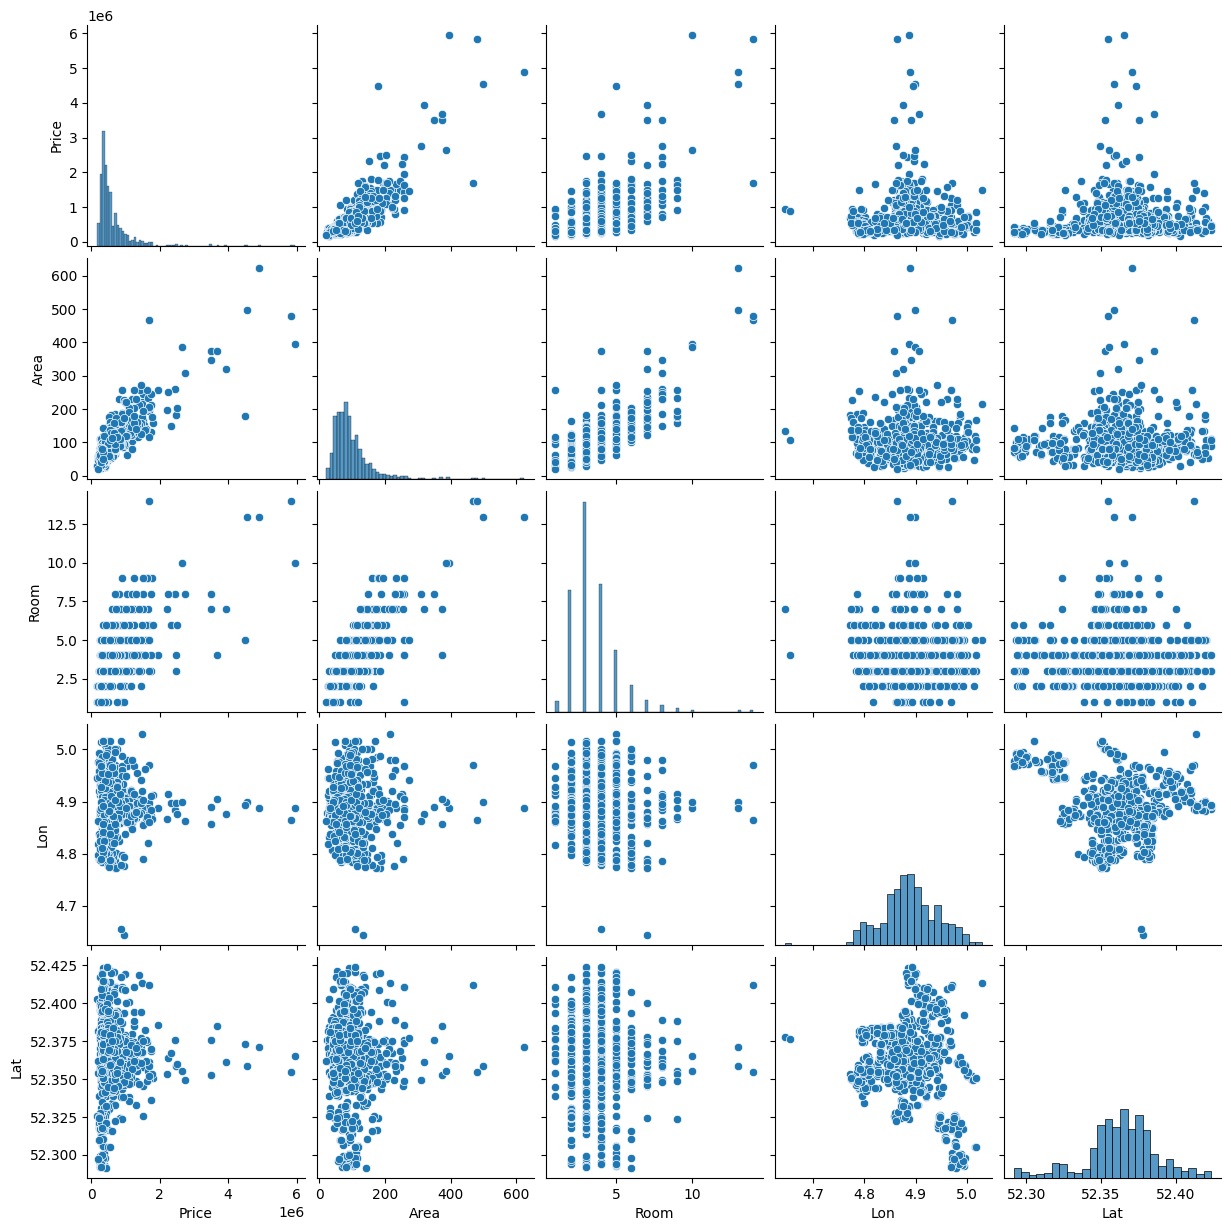

In [ ]:
ax=sns.pairplot(data)

In [ ]:
cleaned_data = data.copy()
cleaned_data.info()

In [ ]:
for column in cleaned_data.columns.drop(['Address', 'Zip']):
    Q1 = cleaned_data[column].quantile(0.25)
    Q3 = cleaned_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    cleaned_data = cleaned_data[(cleaned_data[column] > lower_bound) & (cleaned_data[column] < upper_bound)]

In [ ]:
ax=sns.pairplot(cleaned_data)

In [ ]:
label_encoder = LabelEncoder()
cleaned_data['Address'] = label_encoder.fit_transform(cleaned_data['Address'])
cleaned_data['Zip'] = label_encoder.fit_transform(cleaned_data['Zip'])
cleaned_data.head()

In [ ]:
cleaned_data.describe()

In [ ]:
cmap = sns.diverging_palette(70,20,s=50, l=40, n=6,as_cmap=True)
corrmat= cleaned_data.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrmat,cmap=cmap,annot=True, )

In [ ]:
import math

def haversine_distance(lat1, lon1, lat2, lon2):
    # Радиус Земли в километрах
    R = 6371.0

    # Преобразование координат в радианы
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Разница между широтами и долготами
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Формула гаверсинуса
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Расстояние между двумя точками
    distance = R * c
    return distance

# Координаты центра города (взяты в качестве примера)
lat_center = 52.52  # Широта центра города
lon_center = 13.405  # Долгота центра города

# Применяем функцию для каждой строки датасета и создаем новый столбец с расстоянием до центра
cleaned_data['Distance_to_center'] = cleaned_data.apply(lambda row: haversine_distance(lat_center, lon_center, row['Lat'], row['Lon']), axis=1)

# Выводим первые несколько строк датасета с новым столбцом
cleaned_data.head()


<Axes: >

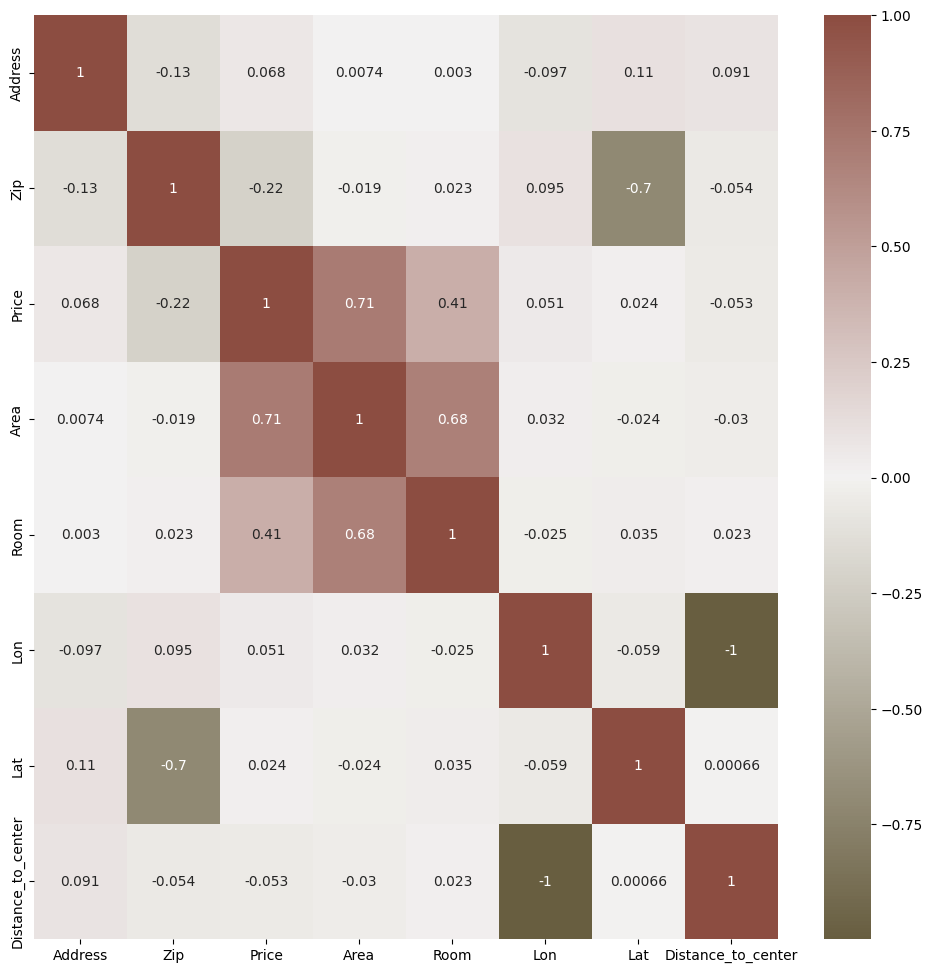

In [ ]:
cmap = sns.diverging_palette(70,20,s=50, l=40, n=6,as_cmap=True)
corrmat= cleaned_data.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrmat,cmap=cmap,annot=True, )

In [ ]:
X = cleaned_data.drop(['Price'], axis=1)
y = cleaned_data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Building pipelins of standard scaler and model for varios regressors.

pipeline_lr=Pipeline([("scalar1",StandardScaler()),
                     ("lr_classifier",LinearRegression())])

pipeline_dt=Pipeline([("scalar2",StandardScaler()),
                     ("dt_classifier",DecisionTreeRegressor())])

pipeline_rf=Pipeline([("scalar3",StandardScaler()),
                     ("rf_classifier",RandomForestRegressor())])


pipeline_kn=Pipeline([("scalar4",StandardScaler()),
                     ("rf_classifier",KNeighborsRegressor())])


pipeline_xgb=Pipeline([("scalar5",StandardScaler()),
                     ("rf_classifier",XGBRegressor())])

# List of all the pipelines
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_kn, pipeline_xgb]

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "LinearRegression", 1: "DecisionTree", 2: "RandomForest",3: "KNeighbors", 4: "XGBRegressor"}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [ ]:
cv_results_rms = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train,scoring="neg_root_mean_squared_error", cv=10)
    cv_results_rms.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

In [ ]:
# Model prediction on test data
predLinear = pipeline_lr.predict(X_test)
predDTree = pipeline_dt.predict(X_test)
predRF = pipeline_rf.predict(X_test)
predKN = pipeline_kn.predict(X_test)
predXGB = pipeline_xgb.predict(X_test)

In [ ]:
# Models Evaluation
print("R^2 Linear:",metrics.r2_score(y_test, predLinear))
print("R^2 DTree:",metrics.r2_score(y_test, predDTree))
print("R^2 RandForest:",metrics.r2_score(y_test, predRF))
print("R^2 KN:",metrics.r2_score(y_test, predKN))
print("R^2 XGB:",metrics.r2_score(y_test, predXGB))

In [ ]:
# Best Model Evaluation
print("R^2 RandForest:",metrics.r2_score(y_test, predRF))
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, predRF))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, predRF))
print("MSE:",metrics.mean_squared_error(y_test, predRF))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, predRF)))

Evalueting models on the non cleared data


In [ ]:
label_encoder = LabelEncoder()
data['Address'] = label_encoder.fit_transform(data['Address'])
data['Zip'] = label_encoder.fit_transform(data['Zip'])
data.head()

In [ ]:
import math

def haversine_distance(lat1, lon1, lat2, lon2):
    # Радиус Земли в километрах
    R = 6371.0

    # Преобразование координат в радианы
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Разница между широтами и долготами
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Формула гаверсинуса
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Расстояние между двумя точками
    distance = R * c
    return distance

# Координаты центра города (взяты в качестве примера)
lat_center = 52.52  # Широта центра города
lon_center = 13.405  # Долгота центра города

# Применяем функцию для каждой строки датасета и создаем новый столбец с расстоянием до центра
data['Distance_to_center'] = data.apply(lambda row: haversine_distance(lat_center, lon_center, row['Lat'], row['Lon']), axis=1)

# Выводим первые несколько строк датасета с новым столбцом
data.head()

In [ ]:
cmap = sns.diverging_palette(70,20,s=50, l=40, n=6,as_cmap=True)
corrmat= data.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrmat,cmap=cmap,annot=True, )

In [ ]:
X = data.drop(['Price'], axis=1)
y = data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Building pipelins of standard scaler and model for varios regressors.

pipeline_lr=Pipeline([("scalar1",StandardScaler()),
                     ("lr_classifier",LinearRegression())])

pipeline_dt=Pipeline([("scalar2",StandardScaler()),
                     ("dt_classifier",DecisionTreeRegressor())])

pipeline_rf=Pipeline([("scalar3",StandardScaler()),
                     ("rf_classifier",RandomForestRegressor())])


pipeline_kn=Pipeline([("scalar4",StandardScaler()),
                     ("rf_classifier",KNeighborsRegressor())])


pipeline_xgb=Pipeline([("scalar5",StandardScaler()),
                     ("rf_classifier",XGBRegressor())])

# List of all the pipelines
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_kn, pipeline_xgb]

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "LinearRegression", 1: "DecisionTree", 2: "RandomForest",3: "KNeighbors", 4: "XGBRegressor"}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [ ]:
cv_results = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train,scoring="neg_root_mean_squared_error", cv=10)
    cv_results_rms.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

LinearRegression: -274609.273854 
DecisionTree: -367889.918588 
RandomForest: -262397.308472 
KNeighbors: -241686.900121 
XGBRegressor: -248387.675842 


In [ ]:
# Model prediction on test data
predLinear = pipeline_lr.predict(X_test)
predDTree = pipeline_dt.predict(X_test)
predRF = pipeline_rf.predict(X_test)
predKN = pipeline_kn.predict(X_test)
predXGB = pipeline_xgb.predict(X_test)

In [ ]:
# Models Evaluation
print("R^2 Linear:",metrics.r2_score(y_test, predLinear))
print("R^2 DTree:",metrics.r2_score(y_test, predDTree))
print("R^2 RandForest:",metrics.r2_score(y_test, predRF))
print("R^2 KN:",metrics.r2_score(y_test, predKN))
print("R^2 XGB:",metrics.r2_score(y_test, predXGB))

R^2 Linear: 0.8280775297564869
R^2 DTree: 0.49150253621198914
R^2 RandForest: 0.8914331337726045
R^2 KN: 0.7710611574182968
R^2 XGB: 0.8026453880402448


In [ ]:
# Best Model Evaluation
print("R^2 RandForest:",metrics.r2_score(y_test, predRF))
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, predRF))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, predRF))
print("MSE:",metrics.mean_squared_error(y_test, predRF))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, predRF)))

R^2 RandForest: 0.8914331337726045
Adjusted R^2: 0.8871151334112877
MAE: 92753.47657608695
MSE: 33058921225.788967
RMSE: 181821.12425620123
